In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# --- Load dataset ---
df = pd.read_csv("../data/classification_data_raw.csv")

features = ['income', 'per_college_educated_x', 'median_contract_rent']
X = df[features]
y = df['gentrified']

# --- Train/test split before SMOTE ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Apply SMOTE to training data only ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Scale training and test data separately ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Use training scaler

# --- Base models ---
lr = LogisticRegression(
    penalty='l2', C=0.01, class_weight='balanced', max_iter=1000, random_state=42
)
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)

# --- Final estimator ---
final_estimator = LogisticRegressionCV(
    cv=5, max_iter=10000, random_state=42
)

# --- Stacking classifier ---
stack_model = StackingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    final_estimator=final_estimator,
    passthrough=True
)

# --- Fit and evaluate ---
stack_model.fit(X_train_scaled, y_train_resampled)
y_pred = stack_model.predict(X_test_scaled)
y_prob = stack_model.predict_proba(X_test_scaled)[:, 1]

print("Stacked Model Performance:")
print(classification_report(y_test, y_pred))


Stacked Model Performance:
              precision    recall  f1-score   support

       False       0.98      0.90      0.94     38880
        True       0.07      0.29      0.11      1002

    accuracy                           0.88     39882
   macro avg       0.53      0.60      0.53     39882
weighted avg       0.96      0.88      0.92     39882



In [3]:
import pandas as pd

df_2035 = pd.read_csv('../data/forecasted_data_2035_true.csv')

X = df_2035[['income_2035', 'college_2035', 'rent_2035']]

X.columns = features


scaled_data = scaler.transform(X)

pred_2035 = stack_model.predict_proba(scaled_data)[:, 1]

df_2035['gentrification_probability_2035'] = pred_2035

df_2035.to_csv('../data/forecasted_probability_2035_ensemble.csv', index=False)



Threshold: 0.00 — Precision: 0.025, Recall: 1.000, F1: 0.049
Threshold: 0.05 — Precision: 0.049, Recall: 0.659, F1: 0.091
Threshold: 0.10 — Precision: 0.054, Recall: 0.547, F1: 0.099
Threshold: 0.15 — Precision: 0.057, Recall: 0.481, F1: 0.102
Threshold: 0.20 — Precision: 0.060, Recall: 0.443, F1: 0.105
Threshold: 0.25 — Precision: 0.062, Recall: 0.411, F1: 0.108
Threshold: 0.30 — Precision: 0.065, Recall: 0.388, F1: 0.111
Threshold: 0.35 — Precision: 0.067, Recall: 0.364, F1: 0.113
Threshold: 0.40 — Precision: 0.069, Recall: 0.342, F1: 0.114
Threshold: 0.45 — Precision: 0.069, Recall: 0.314, F1: 0.113
Threshold: 0.50 — Precision: 0.070, Recall: 0.293, F1: 0.114
Threshold: 0.55 — Precision: 0.072, Recall: 0.273, F1: 0.114
Threshold: 0.60 — Precision: 0.075, Recall: 0.254, F1: 0.116
Threshold: 0.65 — Precision: 0.077, Recall: 0.237, F1: 0.117
Threshold: 0.70 — Precision: 0.081, Recall: 0.219, F1: 0.118
Threshold: 0.75 — Precision: 0.082, Recall: 0.191, F1: 0.115
Threshold: 0.80 — Precis

/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


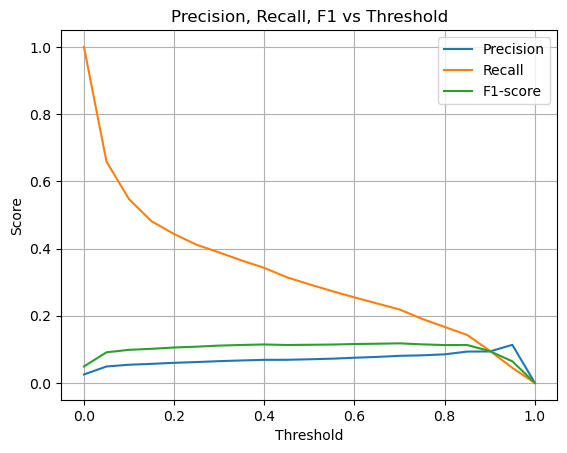

In [4]:
import numpy as np

thresholds = np.arange(0, 1.05, 0.05)

from sklearn.metrics import precision_score, recall_score, f1_score

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} — Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

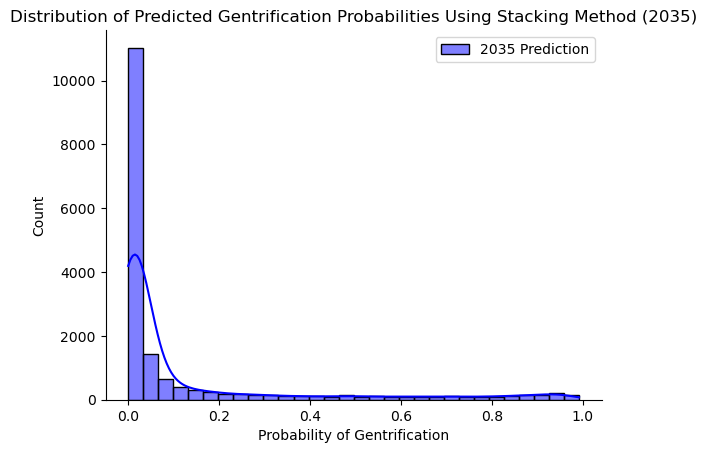

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(pred_2035, bins=30, alpha=0.5, label='2035 Prediction', color='blue', kde=True)
sns.despine()
# sns.histplot(df_combined['gentrification_prob_2031'], bins=30, alpha=0.5, label='2031 Prediction', color='red', kde=True)
plt.title('Distribution of Predicted Gentrification Probabilities Using Stacking Method (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

auc = roc_auc_score(y_test, y_prob)

print("ROC AUC:", auc)
print("PR AUC:", average_precision_score(y_test, y_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


ROC AUC: 0.7205626298842643
PR AUC: 0.06253949704097166


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


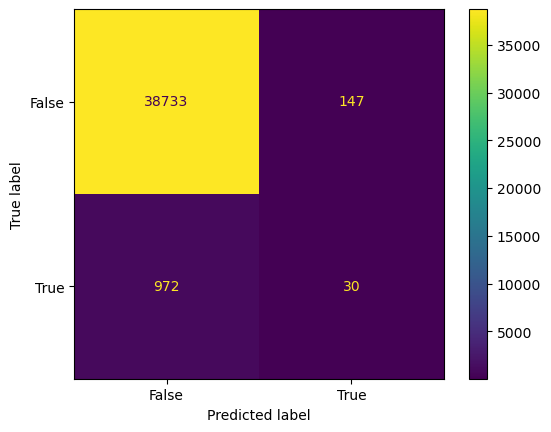

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(stack_model, X_test, y_test)


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using F1 score
f1_scores = cross_val_score(stack_model, X, y, cv=kfold, scoring='f1')

print("Cross-validated F1 scores:", f1_scores)
print("Average F1 score:", np.mean(f1_scores))


ValueError: Found input variables with inconsistent numbers of samples: [17015, 199410]

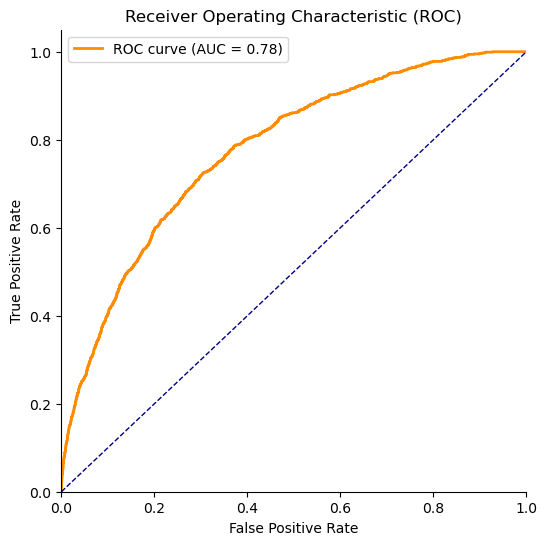

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc="upper left")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()